# Single Shot MultiBox Detector
- 이번 실습은 PyTorch HUB에서 ssd example을 가져와 살펴봅니다.
- 이 모델은 GPU를 사용할 수 있어야 하므로, runtime type을 반드시 GPU로 하고 시작하도록 합니다.
- https://pytorch.org/hub/nvidia_deeplearningexamples_ssd/ 

## SSD
- Author: NVIDIA
- Single Shot MultiBox Detector model for object detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import torch
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')
ssd_model.to('cuda')
ssd_model.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

- 우리가 다운로드한 네트워크는 아래의 coco dataset을 이용하여 학습되었습니다.
- http://cocodataset.org/#home
- 적절한 이미지파일을 가져와서 테스트해봅시다.
- 어떠한 class들을 detect할 수 있는지 아래의 파일에서 확인할 수 있습니다.
- https://raw.githubusercontent.com/hufsbme/T10402101/master/ch13_computer_vision/coco_category_names.txt
- 웹 또는 google drive의 주소를 ,로 구분하여 나열할 수 있습니다.


In [0]:
uris = [
    'https://raw.githubusercontent.com/hufsbme/T10402101/master/ch13_computer_vision/IMG_0367.jpeg',
    #'/content/drive/My Drive/Data/img/IMG_6996.jpeg'
]

- 아래는 그림파일을 적절한 형태의 tensor input으로 변환하고, network의 output을 계산하여 출력된 box들 중에서 의미있는 box를 선택하여 출력하도록 결과를 정리합니다.
- pick_best의 숫자를 낮추게 되면 더 많은 box가 출력될 가능성이 높아집니다. 
- box가 아무것도 출력되지 않는 경우에는 더 작은 값을 사용해 봅니다.

In [0]:
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')
with torch.no_grad():
    detections_batch = ssd_model(tensor)
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.75) for results in results_per_input]    
classes_to_labels = utils.get_coco_object_dictionary()


- SSD의 결과를 시각화하여 확인해봅시다.

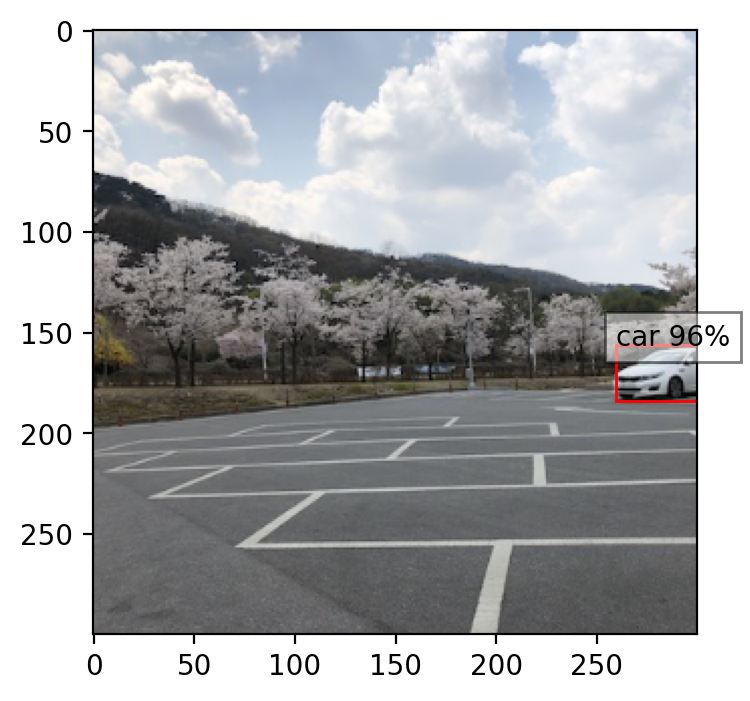

In [4]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1, dpi=200)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()